# 0.0 Imports

In [30]:
import re
import requests
# import torch
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from datetime import datetime


from transformers import AutoTokenizer,AutoModelForSequenceClassification
from bs4 import BeautifulSoup
from tqdm import tqdm  
# from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax
from IPython.display import HTML
from sklearn.metrics import precision_score

In [43]:
def notebook_settings():
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns=None
    pd.options.display.max_rows=None
    pd.set_option( 'display.expand_frame_repr', False)

    sns.set()
notebook_settings()

## Data Mining

In [6]:
# pages = list(range(20, 10000, 10))
# all_reviews = []

# for page in pages:
#     url = f'https://www.yelp.com/biz/fogo-de-chao-brazilian-steakhouse-new-york-6?start={page}'
#     r = requests.get(url)
#     soup = BeautifulSoup(r.text, 'html.parser')

#     # getting comments
#     regex_comment = re.compile('.*comment.*')
#     comment_divs = soup.find_all('p', {'class': regex_comment})
#     comments = [comment.get_text() for comment in comment_divs]

#     # getting stars
#     regex_stars = re.compile('.*rating.*')
#     rating_divs = soup.find_all('div', {'class': 'css-14g69b3'})
#     ratings = [float(div['aria-label'].split()[0]) for div in rating_divs]

#     # getting date
#     date_texts = []
#     for div in soup.find_all('div', {'class': 'css-10n911v'}):
#         date_div = div.find('span', {'class': 'css-chan6m'})
#         date_texts.append(date_div.get_text() if date_div else '')

#     # Extend the all_reviews list with data from the current page
#     all_reviews.extend(list(zip(comments, ratings, date_texts)))

# # Create a DataFrame after the loop using all the collected data
# df2 = pd.DataFrame(all_reviews, columns=['Comment', 'Rating', 'Date'])

# save data into csv
# df2.to_csv('fogo_de_chao_reviews.csv', index=False)

### 0.2 Load Data

In [3]:
# load data
df = pd.read_csv('../data/raw/fogo_de_chao_reviews.csv')

# 1.0 Data Description

## 1.1 Data Dimensions

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  1772 non-null   object 
 1   Rating   1772 non-null   float64
 2   Date     1772 non-null   object 
dtypes: float64(1), object(2)
memory usage: 41.7+ KB


## 1.2 Rename columns


In [5]:
cols_new = ['comment', 'rating', 'date']
df.columns = cols_new

## 1.3 Transform Dtypes

In [6]:
date_format = '%b %d, %Y'
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, date_format))

## 1.4 Descriptive Statistics

### Rating

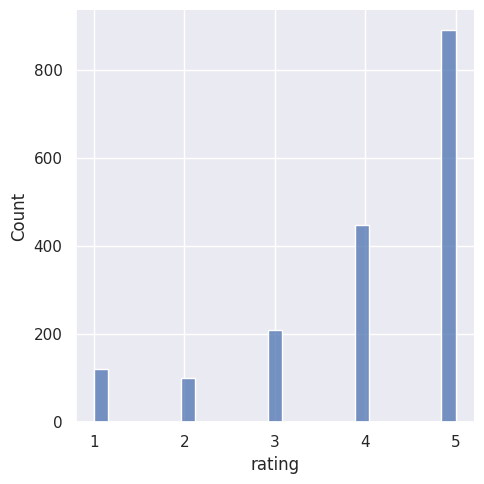

In [11]:
sns.displot(data=df, x='rating');

### Date

In [7]:
df_aux = df.copy()
df_aux['year'] = df['date'].dt.year
df_aux['month'] = df['date'].dt.month

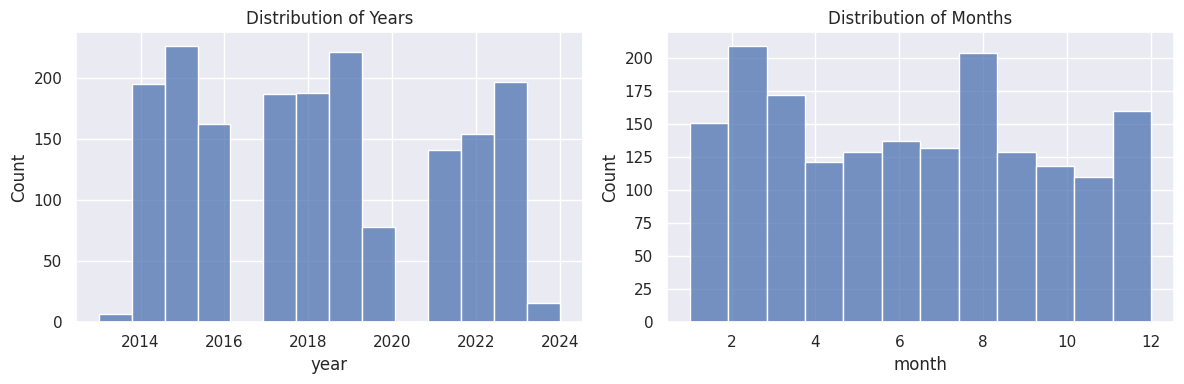

In [8]:
# Definindo o tamanho das figuras
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Barras de Count
sns.histplot(df_aux['year'], ax=axs[0])
axs[0].set_title('Distribution of Years')

# Gráfico 2 - Boxplot de Reason
sns.histplot(df_aux['month'], ax=axs[1])
axs[1].set_title('Distribution of Months')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

# 2.0 Machine Learnign Modeling

## 2.1 VADER Model

In [117]:
X = df.reset_index()
df_vader = df.copy().reset_index()

In [118]:
# define the model
sia = SentimentIntensityAnalyzer()

In [119]:
# run polarity score on the entire dataset
res = {}
for i, row in tqdm(X.iterrows(), total=len(X)):
    text = row['comment']
    my_id = row['index']
    res[my_id] = sia.polarity_scores(text)

  0%|          | 0/1772 [00:00<?, ?it/s]

In [120]:
# merge predictions to the original df
vader = pd.DataFrame(res).T
vader = vader.reset_index()
vader = vader.merge(df_vader, how='left', on='index')
# vader = vader[['index', 'neg', 'neu', 'pos', 'compound', 'rating', 'comment', 'date']]

In [121]:
# define labels
vader['label'] = vader['compound'].apply( lambda x: 'positive' if x >= 0.5 else 'neutral' if x > 0.3 and x < 0.5 else 'negative' )

### 2.1.1 Check the model

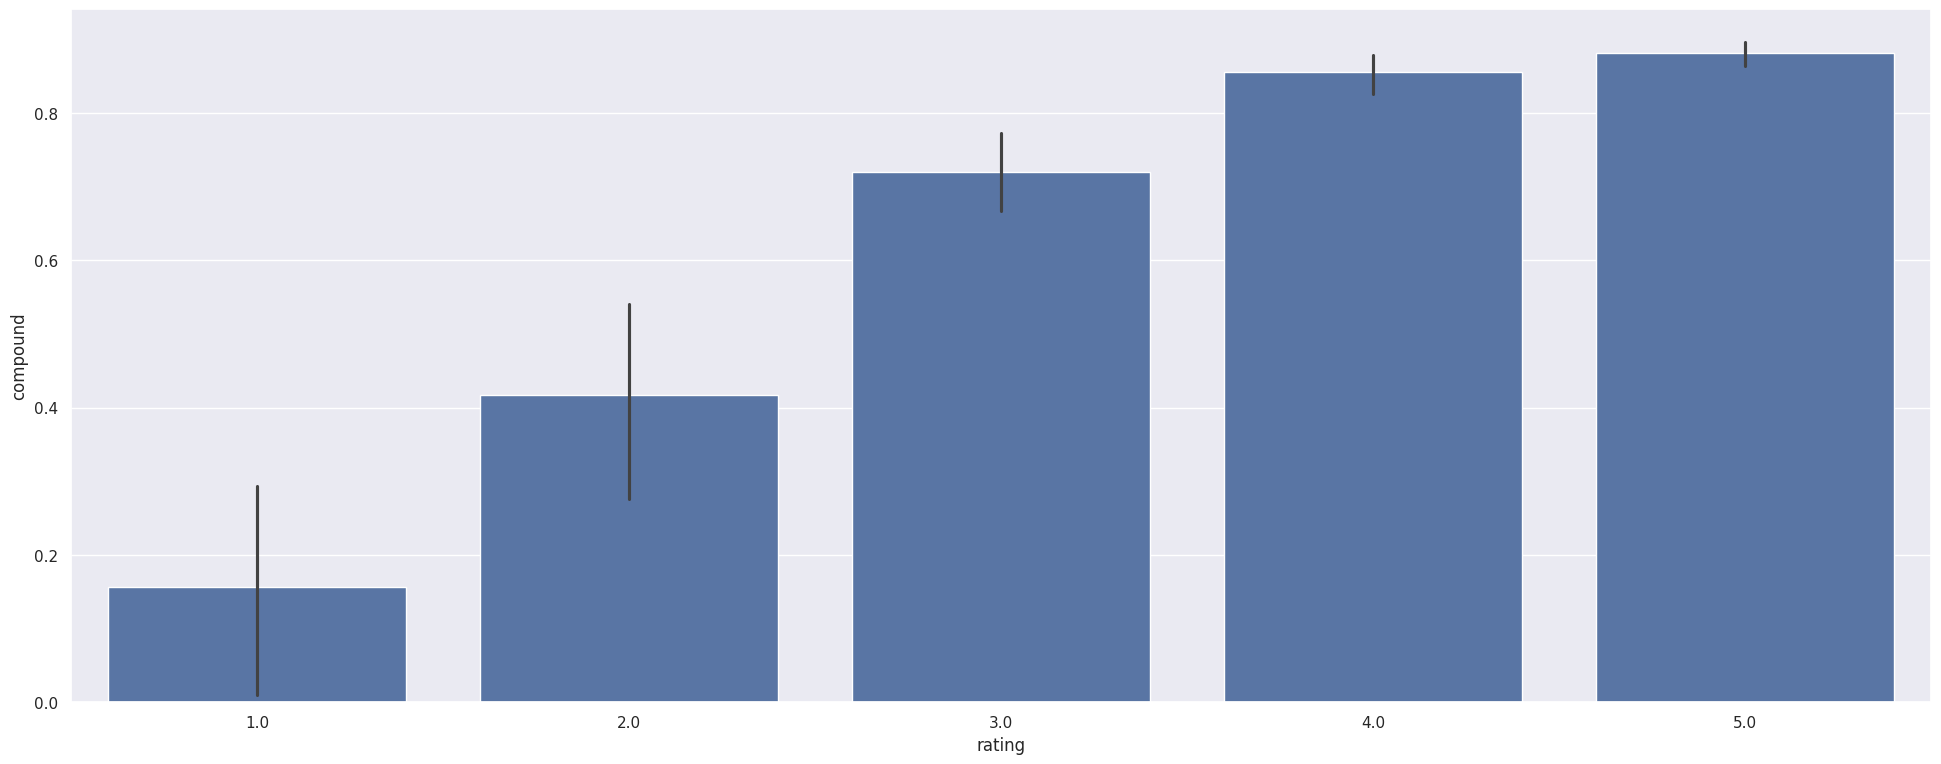

In [122]:
sns.barplot(data=vader, x='rating', y='compound');

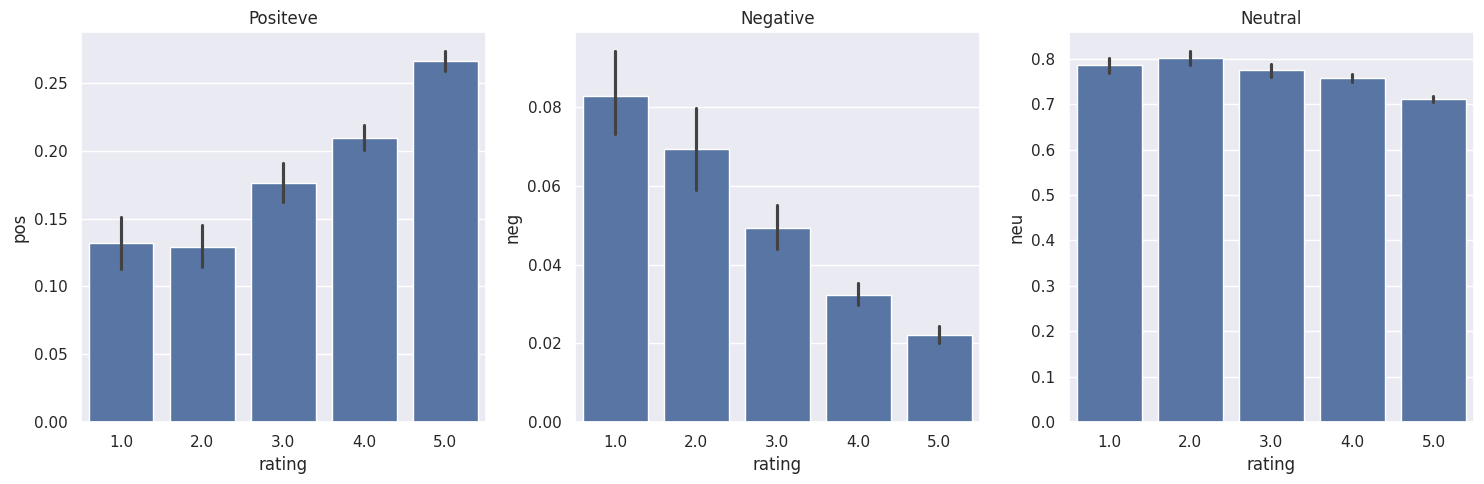

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vader, x='rating', y='pos', ax=axs[0]);
sns.barplot(data=vader, x='rating', y='neg', ax=axs[1]);
sns.barplot(data=vader, x='rating', y='neu', ax=axs[2]);
axs[0].set_title('Positeve')
axs[1].set_title('Negative')
axs[2].set_title('Neutral')
plt.tight_layout()

## 3.0 EDA

### 3.1 Period 2013 - 2024

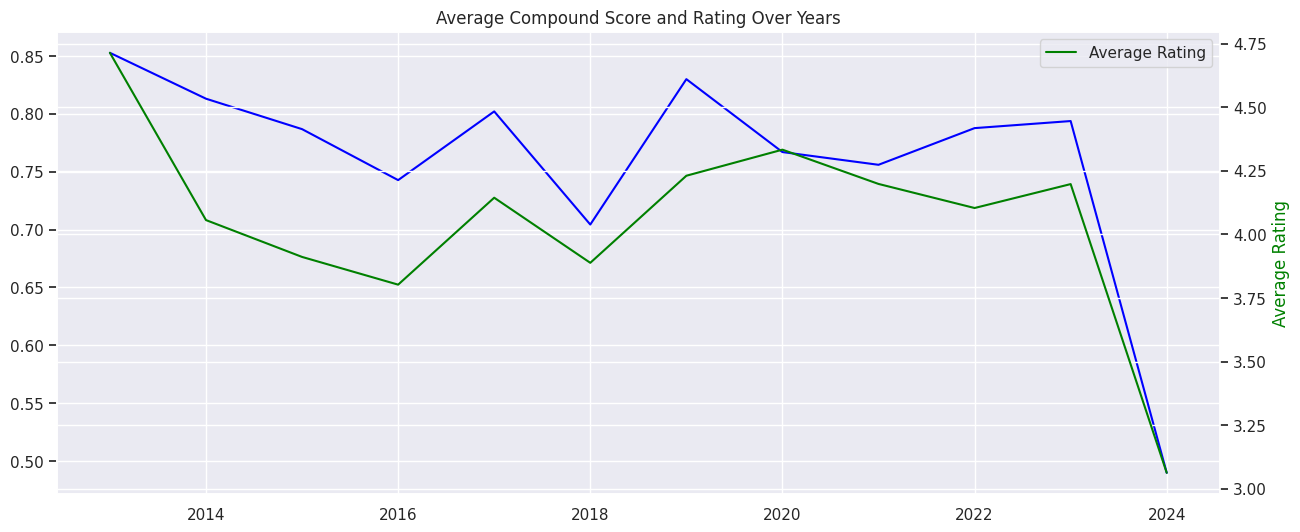

In [124]:
# Comparatio Compound and rating
df_aux1 = vader.copy()
df_aux1['year'] = df_aux1['date'].dt.year
by_year = df_aux1[['year', 'compound', 'rating']].groupby('year').mean().reset_index()

# Plotting using Seaborn lineplot
plt.figure(figsize=(15, 6))

# Plot Compound Score on the primary y-axis
# sns.lineplot(data=by_year, x='year', y='compound', label='Compound Score', color='blue')
plt.plot(by_year['year'],by_year['compound'], label='Compound Score', color='blue')

# Create a secondary y-axis for Average Rating
ax2 = plt.gca().twinx()
# sns.lineplot(data=by_year, x='year', y='rating', label='Average Rating', color='green', ax=ax2)
plt.plot(by_year['year'], by_year['rating'], label='Average Rating', color='green')

# Set title and labels
plt.title('Average Compound Score and Rating Over Years')
plt.xlabel('Year')

# Set y-axis labels
plt.ylabel('Compound Score', color='blue')
ax2.set_ylabel('Average Rating', color='green')

# Show legend
plt.legend()

# Show the plot
plt.show()


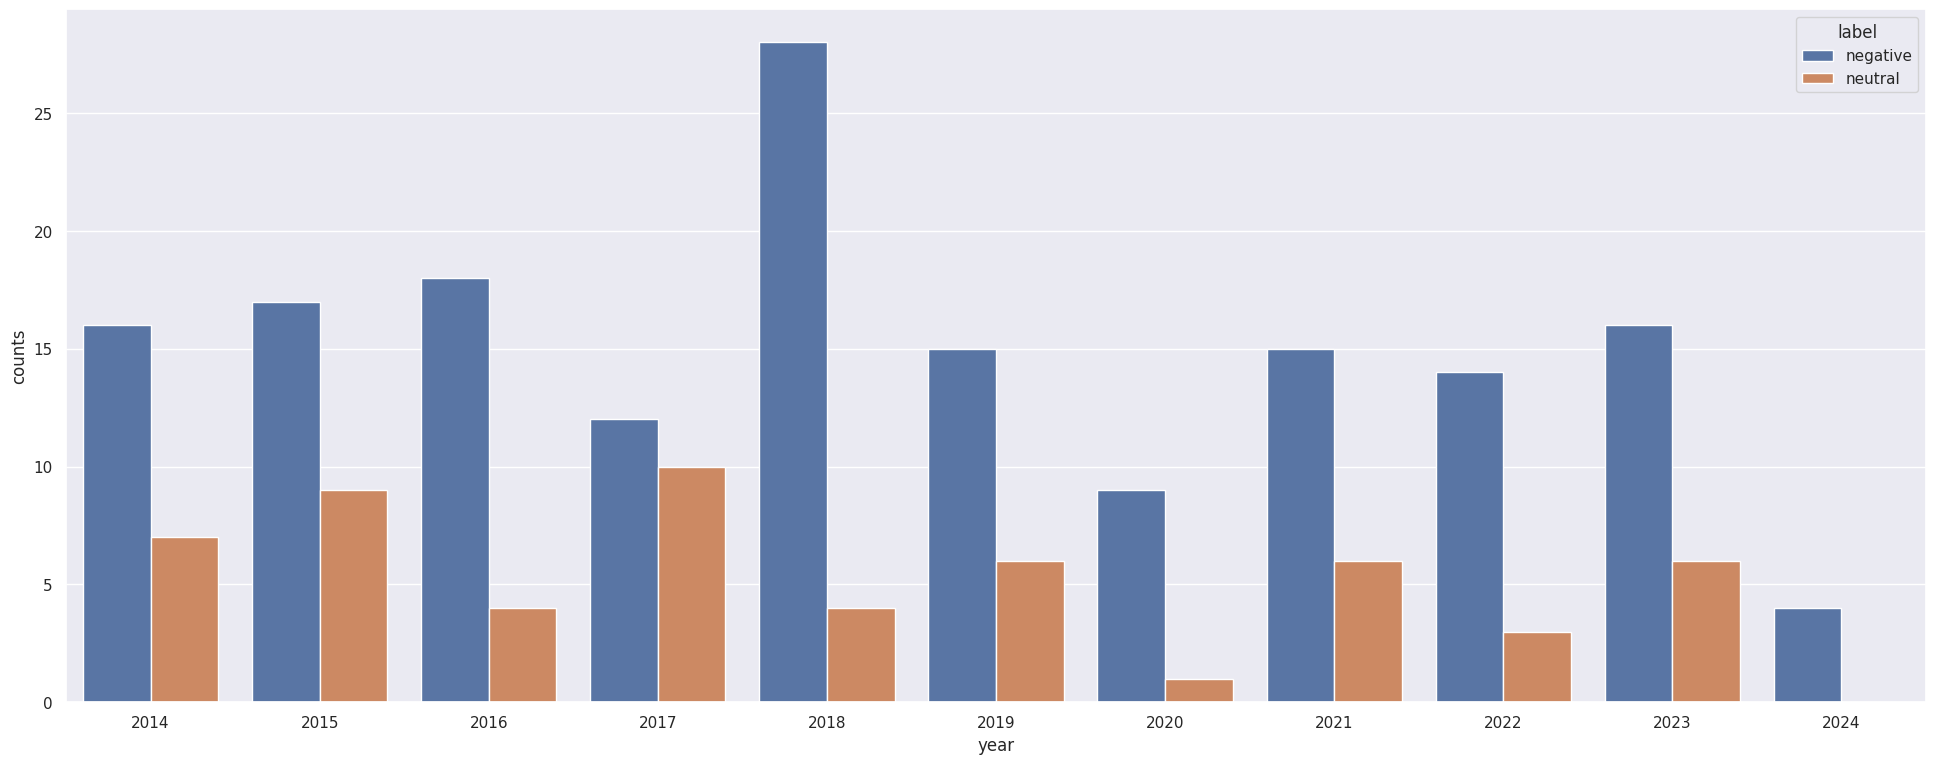

In [125]:
# labels by year
df1 = df_aux1.copy()
df_count = df1.groupby(['year', 'label']).size().reset_index(name='counts')
df_count = df_count[df_count['label'] != 'positive']
sns.barplot(data=df_count, x='year',y='counts', hue='label');

In [126]:
# negative and neutral proportion over positive comments
df_pos = df_aux1[df_aux1['label'] == 'positive']
df_neg = df_aux1[df_aux1['label'] == 'negative']
df_neut = df_aux1[df_aux1['label'] == 'neutral']

by_label_positive = df_pos[['year', 'label']].groupby('year').count().reset_index()
by_label_positive.columns = ['year', 'positive']

by_label_negative = df_neg[['year', 'label']].groupby('year').count().reset_index()
by_label_negative.columns = ['year', 'negative']

by_label_neutral = df_neut[['year', 'label']].groupby('year').count().reset_index()
by_label_neutral.columns = ['year', 'neutral']

by_label = by_label_positive.merge(by_label_negative, how='left', on='year')
by_label = by_label.merge(by_label_neutral, how='left', on='year')
by_label = by_label.fillna(0.0)
by_label['negative'] = by_label['negative'].astype(int)
by_label['neutral'] = by_label['neutral'].astype(int)

# negative percentage
by_label['negative_%'] = (by_label['negative'] / by_label['positive']) * 100
by_label['neutral_%'] = (by_label['neutral'] / by_label['positive']) * 100

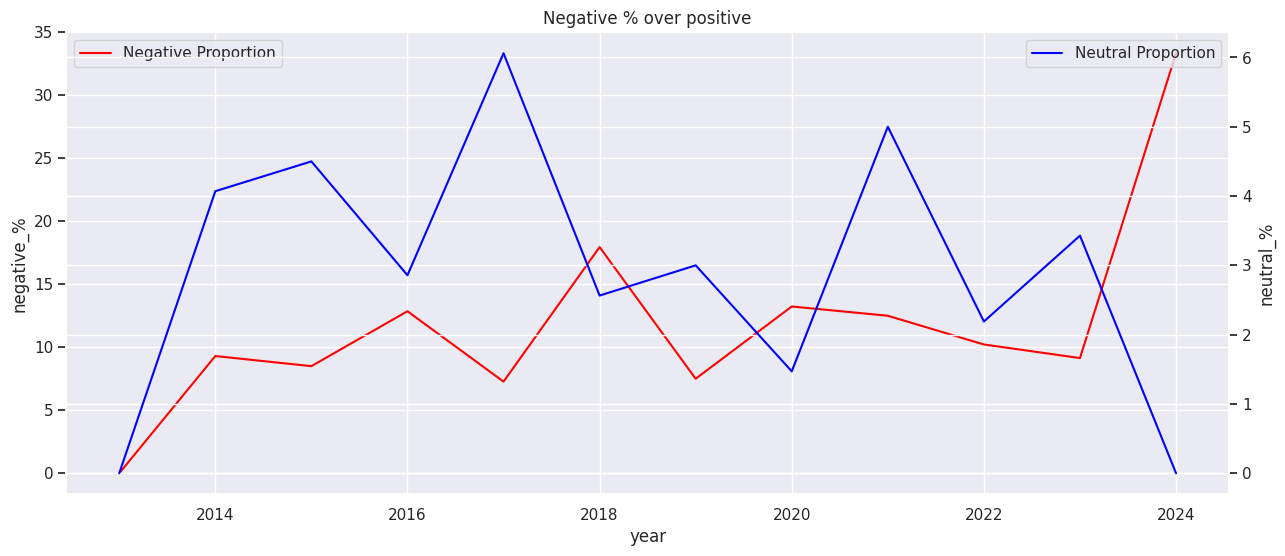

In [127]:
plt.figure(figsize=(15,6))

# plot negative % over positive along the years
sns.lineplot(data=by_label, x='year', y='negative_%', label='Negative Proportion', color='red')

# plot neutral % over positive along the years
ax2 = plt.gca().twinx()
sns.lineplot(data=by_label, x='year', y='neutral_%', label='Neutral Proportion', color='blue', ax=ax2)

# set title
plt.title('Negative % over positive')
plt.legend()
plt.show()

### 3.2 Period 2023-2024

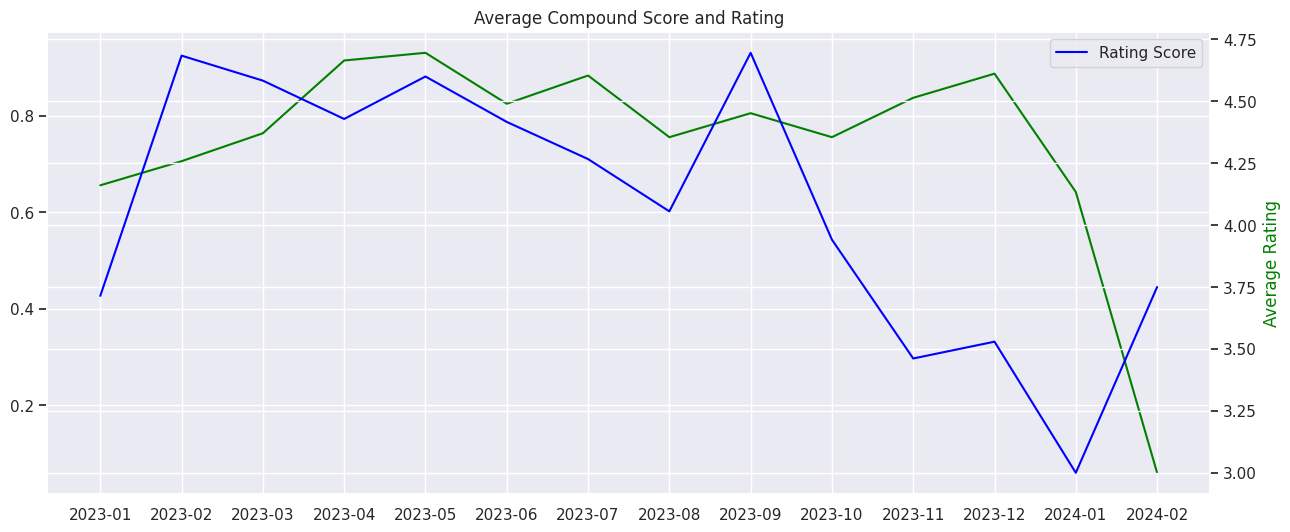

In [128]:
df1 = vader.copy()

# filter period
df1 = df1[ ( df1['date'] > '2023-01-01' ) & ( df1['date'] < '2024-02-18' ) ]

# df_aux1['month'] = df_aux1['date'].dt.month
df1['month-year'] = df1['date'].dt.to_period('M')
by_month = df1[['month-year', 'compound', 'rating']].groupby('month-year').mean().reset_index()

# Plotting using Seaborn lineplot
plt.figure(figsize=(15, 6))

# Plot Compound Score on the primary y-axis
plt.plot(by_month['month-year'].astype(str), by_month['compound'], label='Compound Score', color='green')

# Create a secondary y-axis for Average Rating
ax2 = plt.gca().twinx()
plt.plot(by_month['month-year'].astype(str), by_month['rating'], label='Rating Score', color='blue')


# Set title and labels
plt.title('Average Compound Score and Rating')
plt.xlabel('month-year')

# Set y-axis labels
plt.ylabel('Compound Score', color='blue')
ax2.set_ylabel('Average Rating', color='green')

# Show legend
plt.legend()

# Show the plot
plt.show()

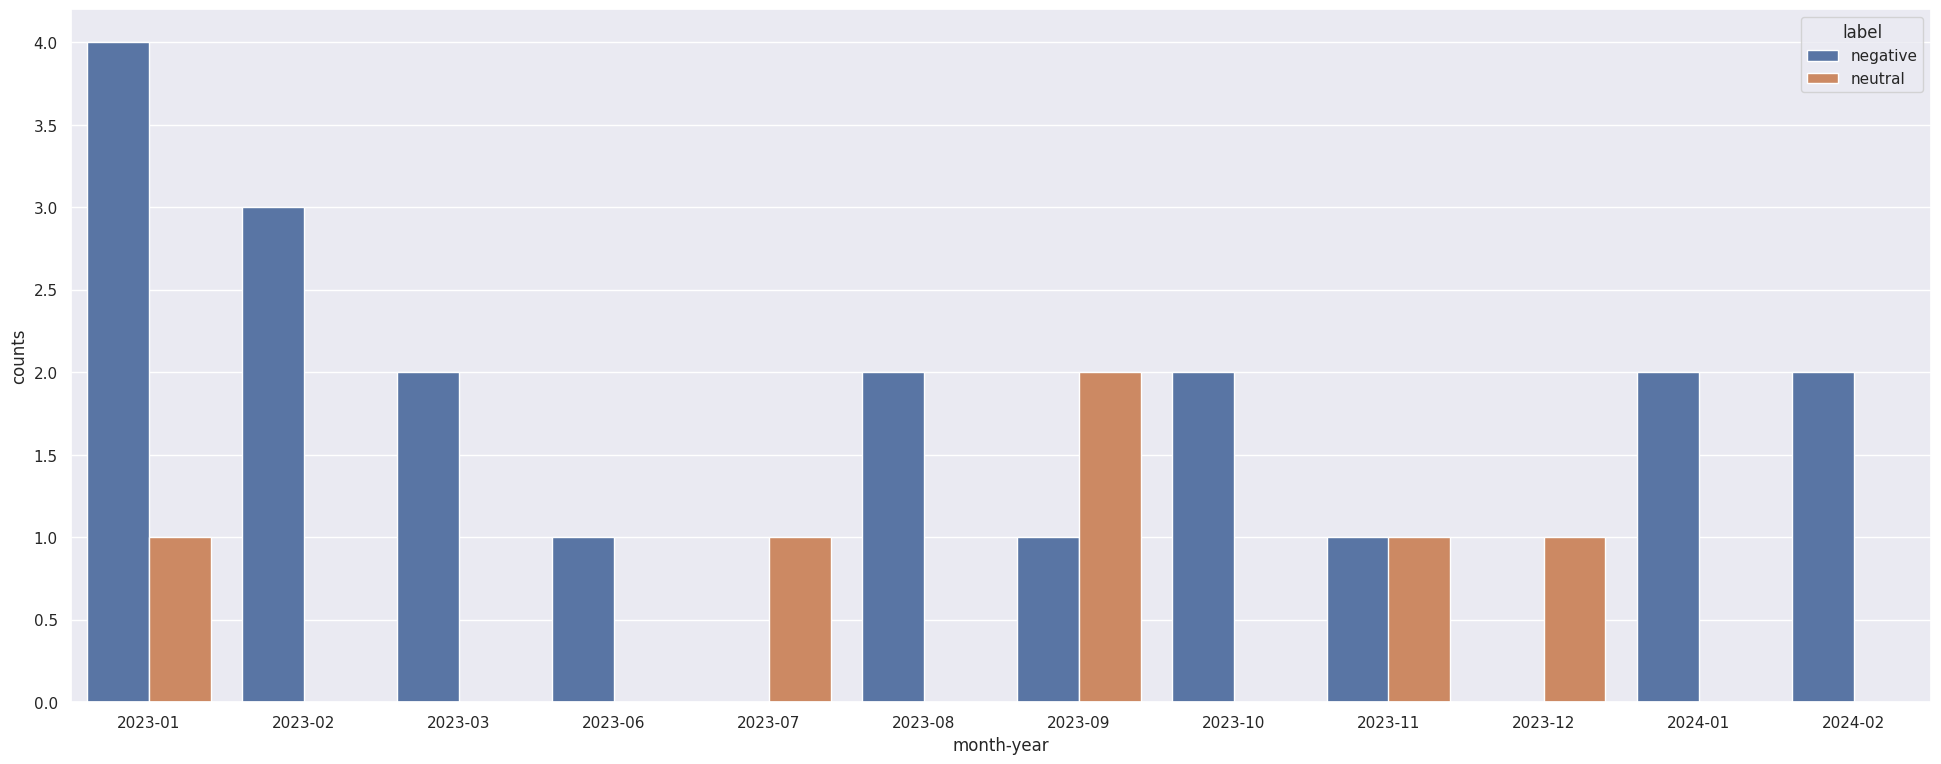

In [129]:
# labels by year
df_count = df1.groupby(['month-year', 'label']).size().reset_index(name='counts')
df_count = df_count[df_count['label'] != 'positive']
sns.barplot(data=df_count, x='month-year',y='counts', hue='label');

In [131]:
# negative and neutral proportion over positive comments
df_pos = df1[df1['label'] == 'positive']
df_neg = df1[df1['label'] == 'negative']
df_neut = df1[df1['label'] == 'neutral']

by_label_positive = df_pos[['month-year', 'label']].groupby('month-year').count().reset_index()
by_label_positive.columns = ['month-year', 'positive']

by_label_negative = df_neg[['month-year', 'label']].groupby('month-year').count().reset_index()
by_label_negative.columns = ['month-year', 'negative']

by_label_neutral = df_neut[['month-year', 'label']].groupby('month-year').count().reset_index()
by_label_neutral.columns = ['month-year', 'neutral']

by_label = by_label_positive.merge(by_label_negative, how='left', on='month-year')
by_label = by_label.merge(by_label_neutral, how='left', on='month-year')
by_label = by_label.fillna(0.0)
by_label['negative'] = by_label['negative'].astype(int)
by_label['neutral'] = by_label['neutral'].astype(int)

# negative percentage
by_label['negative_%'] = (by_label['negative'] / by_label['positive']) * 100
by_label['neutral_%'] = (by_label['neutral'] / by_label['positive']) * 100

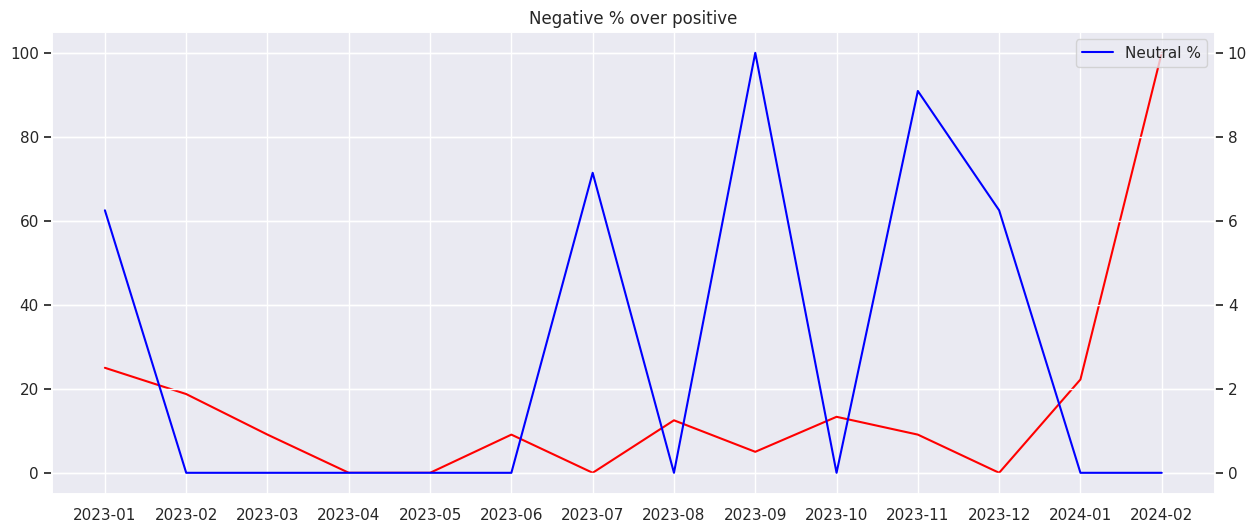

In [132]:
plt.figure(figsize=(15,6))

# plot negative % over positive along the years
plt.plot(by_label['month-year'].astype(str), by_label['negative_%'], label='Negative %', color='red')

# plot neutral % over positive along the years
ax2 = plt.gca().twinx()
plt.plot(by_label['month-year'].astype(str), by_label['neutral_%'], label='Neutral %', color='blue')

# set title
plt.title('Negative % over positive')
plt.legend()
plt.show()